In [22]:
cd C:\Users\malkabir\OneDrive - University of New Mexico\All Personal Project\2020 M5 Forecasting Everything

C:\Users\malkabir\OneDrive - University of New Mexico\All Personal Project\2020 M5 Forecasting Everything


- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
- https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3

In [23]:
#standard
import pandas as pd, numpy as np
from numpy.random import randn

#stat

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic

#plotting

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

#statistical method
from pylab import rcParams
import statsmodels.api as sm

import warnings
import itertools
import re
import time

warnings.filterwarnings("ignore")
%matplotlib inline

In [24]:
#read raw data
calendar=pd.read_csv("RawData/calendar.csv")
#read Raw sell_prices data
sell_prices=pd.read_csv("RawData/sell_prices.csv")
#Read sales_train_validation raw data
sales_train_validation=pd.read_csv("RawData/sales_train_validation.csv")

#make some copy
sell=sell_prices.copy()
cal=calendar.copy()
stv=sales_train_validation.copy()

In [25]:
sales_long = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'd', value_name = 'unit_sold')
sales_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,unit_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [26]:
# merge 
df_t = pd.merge(sales_long, calendar, how = 'left', on = ['d'])
df_t.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,unit_sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [27]:
df_ti=df_t[['date','id','unit_sold']]
df_ti.head()

,date,id,unit_sold
0,2011-01-29,HOBBIES_1_001_CA_1_validation,0
1,2011-01-29,HOBBIES_1_002_CA_1_validation,0
2,2011-01-29,HOBBIES_1_003_CA_1_validation,0
3,2011-01-29,HOBBIES_1_004_CA_1_validation,0
4,2011-01-29,HOBBIES_1_005_CA_1_validation,0


In [28]:
df_ti.shape

(58327370, 3)

In [32]:
df_ti['unit_sold'].value_counts().head()

0    39777094
1     7753194
2     3894493
3     2098127
4     1279524
Name: unit_sold, dtype: int64

In [35]:
df_tim=df_ti.set_index('date')
df_tim.head()

,id,unit_sold
date,,
2011-01-29,HOBBIES_1_001_CA_1_validation,0
2011-01-29,HOBBIES_1_002_CA_1_validation,0
2011-01-29,HOBBIES_1_003_CA_1_validation,0
2011-01-29,HOBBIES_1_004_CA_1_validation,0
2011-01-29,HOBBIES_1_005_CA_1_validation,0


In [36]:
df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold'].head()

date
2011-01-29    0
2011-01-30    0
2011-01-31    0
2011-02-01    0
2011-02-02    0
Name: unit_sold, dtype: int64

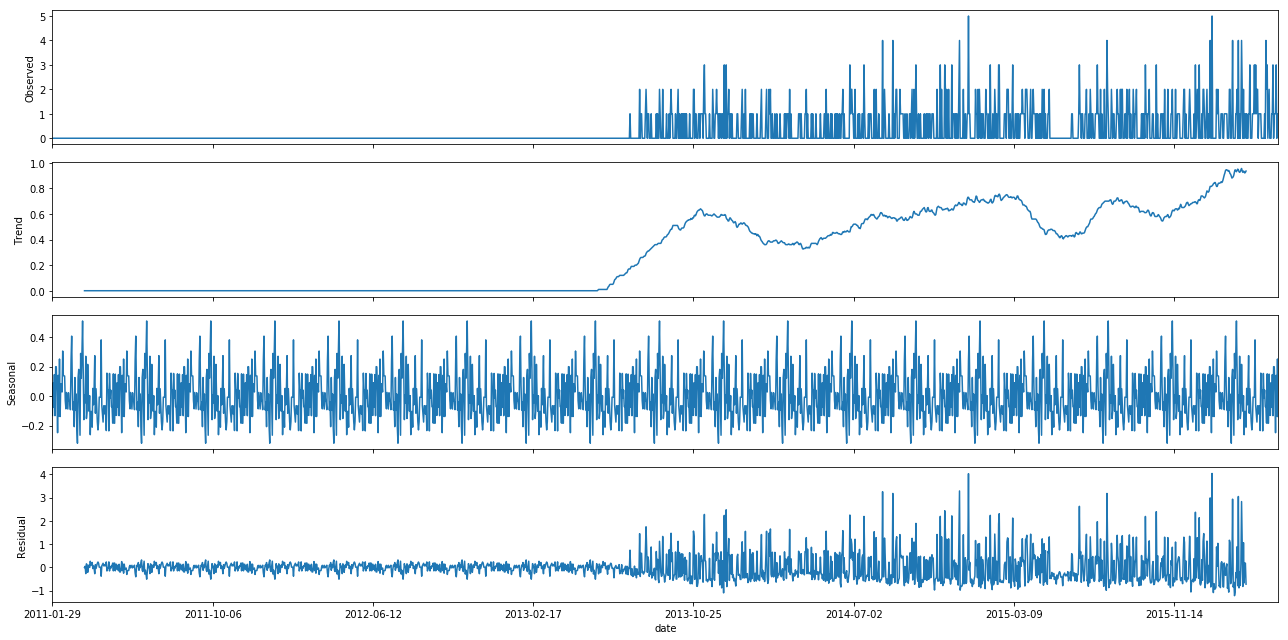

In [37]:
#Check the sesonality, trend and randomness of property price

rcParams['figure.figsize'] = 18, 9
decomposition = sm.tsa.seasonal_decompose(df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold'], model='additive',freq=100)
fig = decomposition.plot()
plt.show()

# Arima for a single product

In [123]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts, order=(0, 1, 1))
mod = model.fit()

In [127]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.unit_sold   No. Observations:                 1912
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3116.394
Method:                       css-mle   S.D. of innovations              1.234
Date:                Sun, 12 Jul 2020   AIC                           6238.789
Time:                        11:09:36   BIC                           6255.456
Sample:                    01-30-2011   HQIC                          6244.923
                         - 04-24-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0002      0.001     -0.154      0.877      -0.002       0.002
ma.L1.D.unit_sold    -0.9600      0.007   -128.197      0.000      -0.975      -0.945
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0417           +0.0000j            1.0417            0.0000
-----------------------------------------------------------------------------
"""

# Sarimax for a single product

In [109]:
ts=df_tim[df_tim['id']=='FOODS_1_001_CA_1_validation']['unit_sold']
ts.head()

date
2011-01-29    3
2011-01-30    0
2011-01-31    0
2011-02-01    1
2011-02-02    4
Name: unit_sold, dtype: int64

In [110]:
#Choose best best_order, best_seasonal_order based on model aic

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_order = None
best_mdl = None
best_seasonal_order=None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            tmp_aic = results.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order=param
                best_seasonal_order=param_seasonal
                
        except:
            continue

print(f'ARIMA{best_order}x{best_order}12 - AIC:{best_aic}')

ARIMA(0, 1, 1)x(0, 1, 1)12 - AIC:6185.194594273186


In [111]:
#Arima model
mod = sm.tsa.statespace.SARIMAX(ts,order=(0, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False).fit()

In [112]:
print(mod.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0469      0.007   -150.356      0.000      -1.061      -1.033
ar.S.L12      -0.0363      0.024     -1.495      0.135      -0.084       0.011
ma.S.L12      -1.0072      0.014    -73.600      0.000      -1.034      -0.980
sigma2         1.3768      0.039     35.138      0.000       1.300       1.454


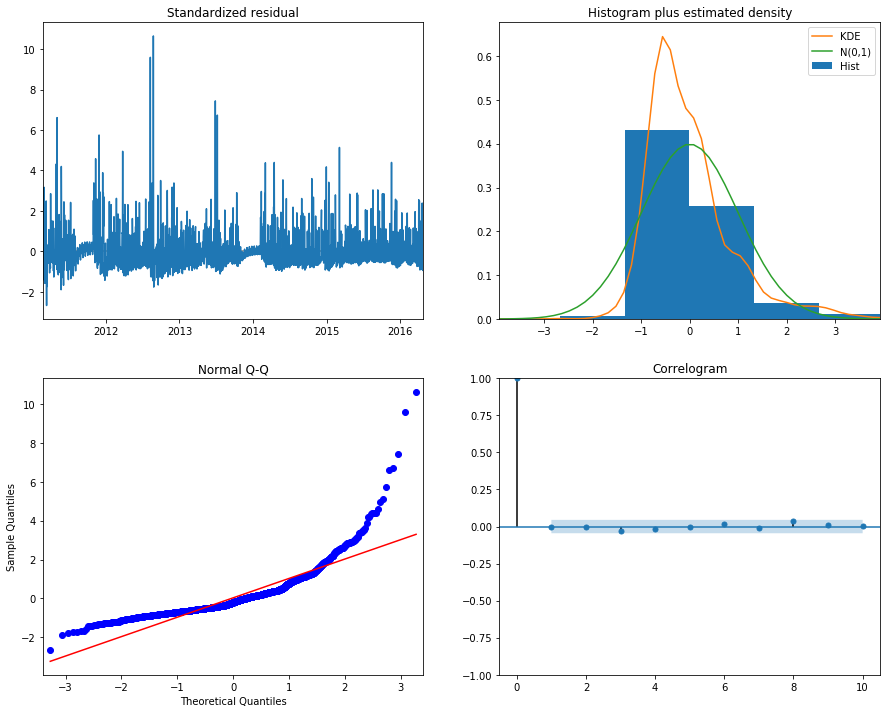

In [113]:
mod.plot_diagnostics(figsize=(15, 12))
plt.show()

In [117]:
pred = mod.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_ci = pred.conf_int()

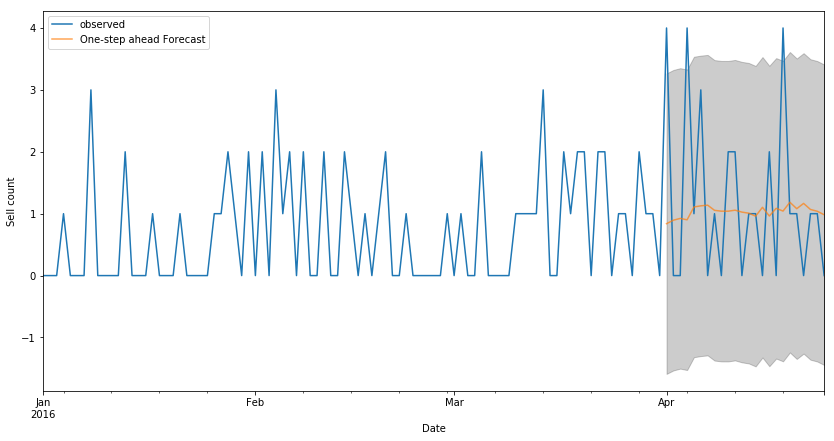

In [119]:
ts.index = pd.to_datetime(ts.index, format="%Y-%m-%d") # needed to add to match the date
ax = ts['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sell count')
plt.legend()
plt.show()

In [120]:
y_forecasted = pred.predicted_mean
y_truth = df_tim[df_tim['id']=='HOBBIES_1_001_CA_1_validation']['unit_sold']['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1.25
The Root Mean Squared Error of our forecasts is 1.12


# Lets do it for all and store in the submission file

In [11]:
def m5forecasting(walmartdata):
    p = d = q = range(1, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    best_aic = np.inf
    best_order = None
    best_mdl = None
    best_seasonal_order=None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(walmartdata,order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                tmp_aic = results.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order=param
                    best_seasonal_order=param_seasonal


                #print('ARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
            except:
                continue

    #print('ARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    mod = sm.tsa.statespace.SARIMAX(walmartdata,order=best_order,seasonal_order=best_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    return results.predict(alpha=0.05, start=1913, end=1969)

In [12]:
cnames=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28']
submission_df = pd.DataFrame(columns=cnames)

In [14]:
import time
start_time = time.time()

for i in df_tim.id.to_list()[0:10]:
    result=m5forecasting(df_tim[df_tim['id']==i]['unit_sold']).to_list()
    submission_df.loc[i]=result[0:28]
    new_i = re.sub("validation", "evaluation", i)
    submission_df.loc[new_i]=result[28:56]
print(f"--- %s seconds ---{time.time() - start_time}")

--- %s seconds ---108.6149914264679


In [30]:
submission_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
HOBBIES_1_001_CA_1_validation,1.056513,1.093881,1.157467,0.948048,0.998160,1.001263,1.051262,1.045668,1.188272,0.955197,...,1.060124,1.054626,1.229012,0.948592,0.922529,0.922017,1.056567,1.111586,1.174130,1.001870
HOBBIES_1_001_CA_1_evaluation,1.000684,1.020554,1.069712,1.064212,1.238054,0.958445,0.932075,0.931563,1.066137,1.121161,...,0.941651,0.941139,1.075713,1.130737,1.193280,1.021031,1.019830,1.039705,1.088863,1.083362
HOBBIES_1_002_CA_1_validation,0.159096,0.123120,0.161364,0.129949,0.148822,0.085924,0.173978,0.180266,0.155095,0.180085,...,0.174921,0.181213,0.156038,0.181027,0.149776,0.137275,0.169520,0.125545,0.163284,0.131838
HOBBIES_1_002_CA_1_evaluation,0.150708,0.087811,0.175864,0.182157,0.156982,0.181971,0.150720,0.138219,0.170464,0.126488,...,0.151663,0.139162,0.171407,0.127432,0.165171,0.133725,0.152595,0.089697,0.177751,0.184043


In [31]:
submission_df.reset_index().rename(columns={'index':'id'})

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.056513,1.093881,1.157467,0.948048,0.998160,1.001263,1.051262,1.045668,1.188272,...,1.060124,1.054626,1.229012,0.948592,0.922529,0.922017,1.056567,1.111586,1.174130,1.001870
1,HOBBIES_1_001_CA_1_evaluation,1.000684,1.020554,1.069712,1.064212,1.238054,0.958445,0.932075,0.931563,1.066137,...,0.941651,0.941139,1.075713,1.130737,1.193280,1.021031,1.019830,1.039705,1.088863,1.083362
2,HOBBIES_1_002_CA_1_validation,0.159096,0.123120,0.161364,0.129949,0.148822,0.085924,0.173978,0.180266,0.155095,...,0.174921,0.181213,0.156038,0.181027,0.149776,0.137275,0.169520,0.125545,0.163284,0.131838
3,HOBBIES_1_002_CA_1_evaluation,0.150708,0.087811,0.175864,0.182157,0.156982,0.181971,0.150720,0.138219,0.170464,...,0.151663,0.139162,0.171407,0.127432,0.165171,0.133725,0.152595,0.089697,0.177751,0.184043


# For Submission

In [15]:
cnames=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28']
submission = pd.DataFrame(columns=cnames)

In [16]:
import time
start_time = time.time()

for i in df_tim.id.to_list():
    result=m5forecasting(df_tim[df_tim['id']==i]['unit_sold']).to_list()
    submission.loc[i]=result[0:28]
    new_i = re.sub("validation", "evaluation", i)
    submission.loc[new_i]=result[28:56]
print(f"--- %s seconds ---{time.time() - start_time}")

KeyboardInterrupt: 

In [17]:
submission=submission.reset_index().rename(columns={'index':'id'})
submission.to_csv("submission")

PermissionError: [Errno 13] Permission denied: 'submission'